# Feed-Forward Neural Network

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from system_identification.ffnn import FeedForwardNeuralNetwork
from system_identification.load_assignment_data import load_net_example_ff

## 1D

In [3]:
def foo(x):
    return 0.8 * np.tanh(x * 0.4 - 0.7) + 2.1

# def f(x):
#     return x[0]**2

# def f(x):
#     return -0.8 * np.tanh(x[0] * 3) + x[1]**2 + 1

inputs = np.linspace(-5, 10, 10000)
reference_outputs = np.array(list(map(foo, inputs)))
reference_outputs_noisy = reference_outputs + np.random.normal(0, 0.1, size=reference_outputs.shape)

inputs = inputs.reshape(-1, 1, 1)
reference_outputs = reference_outputs.reshape(-1, 1, 1)
reference_outputs_noisy = reference_outputs_noisy.reshape(-1, 1, 1)

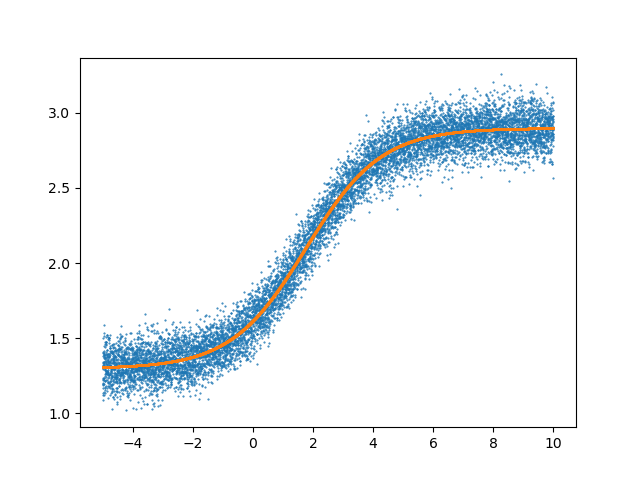

In [4]:
plt.figure()
plt.plot(inputs[:, 0, 0], reference_outputs_noisy[:, 0, 0], ".", markersize=1)
plt.plot(inputs[:, 0, 0], reference_outputs[:, 0, 0], ".", markersize=1)

### Levenberg-Marquardt training

In [12]:
model = FeedForwardNeuralNetwork.new(
    n_inputs=1,
    n_outputs=1,
    n_hidden=3,
    input_range=[[-1, 1]],
)
model

<FeedForwardNeuralNetwork
 n_inputs=1
 n_hidden=3
 n_outputs=1>

In [13]:
model.train(
    inputs,
    reference_outputs_noisy,
    epochs=1000,
    goal=1e-6,
    train_log_freq=1,
    method="trainlm",
    mu=10.,
    alpha=0.95)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
model.training_log

<xarray.Dataset>
Dimensions:                (epoch: 1000, i: 10000, j: 1, k: 3, l: 2, m: 1, n: 4)
Coordinates:
  * epoch                  (epoch) int64 1 2 3 4 5 6 ... 996 997 998 999 1000
Dimensions without coordinates: i, j, k, l, m, n
Data variables: (12/15)
    gradient               (epoch) float64 5.231e+04 7.047e+04 ... 4.512e+04
    error_training_data    (epoch, i) float64 0.4213 0.5003 ... -0.007124
    error_validation_data  (epoch, j) float64 nan nan nan nan ... nan nan nan
    error_training_jb      (epoch) float64 819.2 1.041e+03 587.0 ... 3.097 3.097
    error_training_jbp     (epoch) float64 1.304e-178 7.933e-227 ... 0.2126
    error_training_skew    (epoch) float64 0.009598 -0.08891 ... -0.04283
    ...                     ...
    error_validation_skew  (epoch) float64 nan nan nan nan ... nan nan nan nan
    error_validation_kurt  (epoch) float64 nan nan nan nan ... nan nan nan nan
    weights_0              (epoch, k, l) float64 -0.6945 0.3972 ... 0.2942
    weights_1              (epoch, m, n) float64 2.252 0.8063 ... -0.001494
    min_residual_epoch     float64 nan
    min_jb_epoch           float64 nan

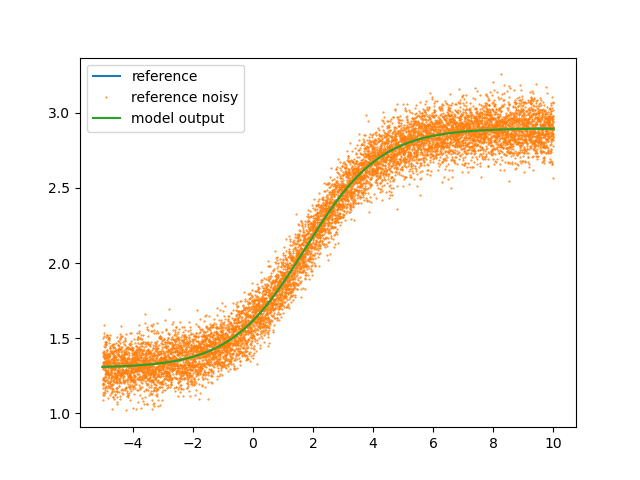

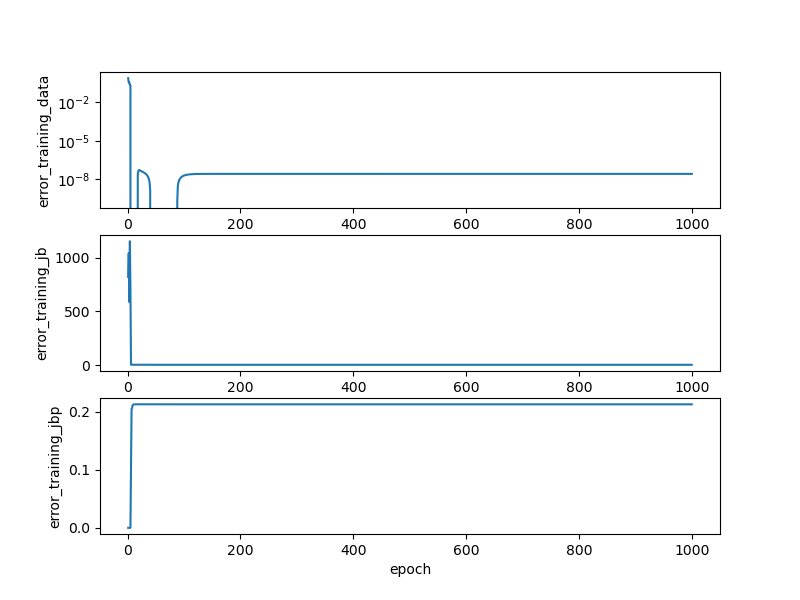

In [15]:
fig = plt.figure()
outputs = model.evaluate(inputs)
plt.plot(inputs.squeeze(), reference_outputs.squeeze(), label="reference")
plt.plot(inputs.squeeze(), reference_outputs_noisy.squeeze(), ".", markersize=1, label="reference noisy")
plt.plot(inputs.squeeze(), outputs.squeeze(), label="model output")
plt.legend()

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
model.training_log.error_training_data.mean("i").plot(ax=axs[0])
axs[0].set_yscale("log")
model.training_log.error_training_jb.plot(ax=axs[1])
model.training_log.error_training_jbp.plot(ax=axs[2])

### Back propagation

In [16]:
model = FeedForwardNeuralNetwork.new(
    n_inputs=1,
    n_outputs=1,
    n_hidden=1,
    input_range=[[-1, 1]],
)
model

<FeedForwardNeuralNetwork
 n_inputs=1
 n_hidden=1
 n_outputs=1>

In [17]:
model.train(
    inputs,
    reference_outputs,
    epochs=10000,
    goal=1e-6,
    train_log_freq=1,
    method="trainbp",
    eta=0.001,
    alpha=1.001)

  0%|          | 0/10000 [00:00<?, ?it/s]

Goal met


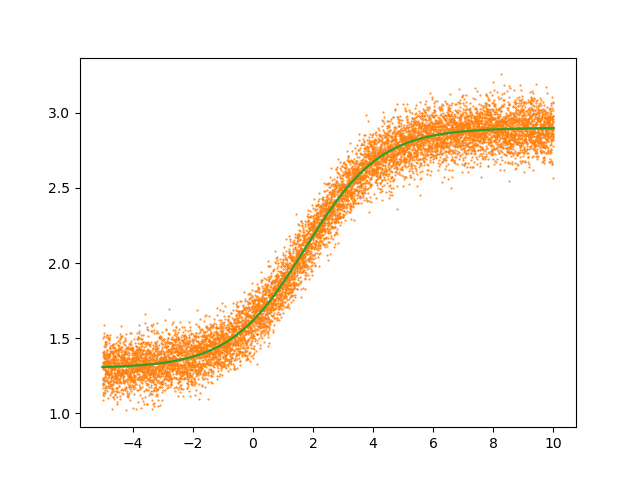

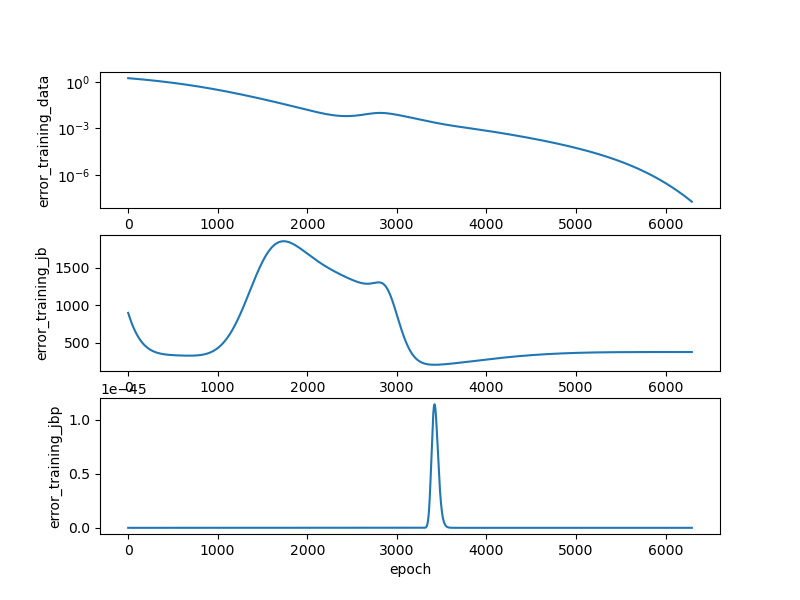

In [18]:
fig = plt.figure()
outputs = model.evaluate(inputs)
plt.plot(inputs.squeeze(), reference_outputs.squeeze())
plt.plot(inputs.squeeze(), reference_outputs_noisy.squeeze(), ".", markersize=1)
plt.plot(inputs.squeeze(), outputs.squeeze())

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
model.training_log.error_training_data.mean("i").plot(ax=axs[0])
axs[0].set_yscale("log")
model.training_log.error_training_jb.plot(ax=axs[1])
model.training_log.error_training_jbp.plot(ax=axs[2])

## 2D

In [19]:
input_range = np.array([(-1, 1), (-3, 5)])


def foo(x):
    return -x[0]**2 + np.sin(x[1]*2)


resolution = 100
inputs = np.array(tuple(product(np.linspace(*input_range[0, :], resolution),
                                np.linspace(*input_range[1, :], resolution))))

reference_outputs = np.array(list(map(foo, inputs)))
reference_outputs_noisy = reference_outputs + np.random.normal(0, 0.1, size=reference_outputs.shape)

inputs = inputs[..., None]
reference_outputs = reference_outputs.reshape(-1, 1, 1)
reference_outputs_noisy = reference_outputs_noisy.reshape(-1, 1, 1)

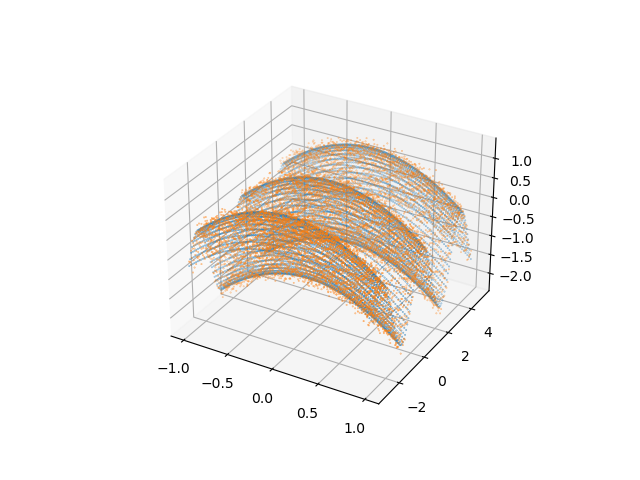

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs_noisy.squeeze(), s=0.1)

### Levenberg-Marquardt training

In [21]:
model = FeedForwardNeuralNetwork.new(
    n_inputs=2,
    n_outputs=1,
    n_hidden=10,
    input_range=input_range,
)
model

<FeedForwardNeuralNetwork
 n_inputs=2
 n_hidden=10
 n_outputs=1>

In [22]:
model.train(
    inputs,
    reference_outputs_noisy,
    epochs=500,
    goal=1e-6,
    train_log_freq=1,
    method="trainlm",
    mu=10.,
    alpha=0.99
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
model.training_log

<xarray.Dataset>
Dimensions:                (epoch: 500, i: 10000, j: 1, k: 10, l: 3, m: 1, n: 11)
Coordinates:
  * epoch                  (epoch) int64 1 2 3 4 5 6 ... 495 496 497 498 499 500
Dimensions without coordinates: i, j, k, l, m, n
Data variables: (12/15)
    gradient               (epoch) float64 1.384e+05 1.417e+05 ... 1.352e+06
    error_training_data    (epoch, i) float64 -0.5868 -0.6335 ... 0.245
    error_validation_data  (epoch, j) float64 nan nan nan nan ... nan nan nan
    error_training_jb      (epoch) float64 139.5 31.99 399.9 ... 9.008 9.006
    error_training_jbp     (epoch) float64 5.024e-31 1.133e-07 ... 0.01107
    error_training_skew    (epoch) float64 -0.1514 -0.008994 ... 0.05993 0.05992
    ...                     ...
    error_validation_skew  (epoch) float64 nan nan nan nan ... nan nan nan nan
    error_validation_kurt  (epoch) float64 nan nan nan nan ... nan nan nan nan
    weights_0              (epoch, k, l) float64 -3.561 0.01343 ... -1.124
    weights_1              (epoch, m, n) float64 -25.21 3.569 ... -14.14 -2.612
    min_residual_epoch     float64 nan
    min_jb_epoch           float64 nan

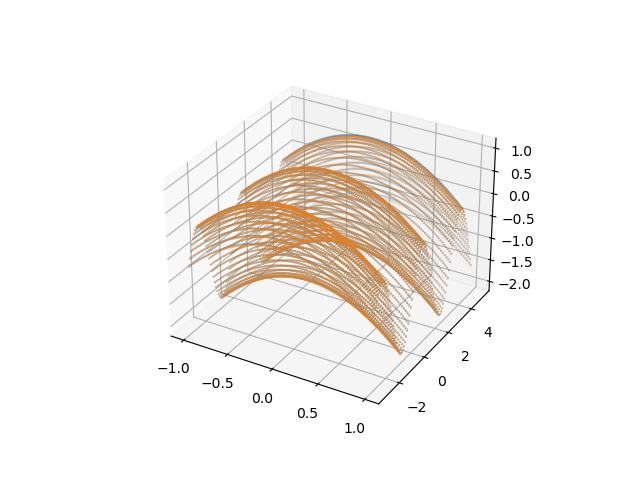

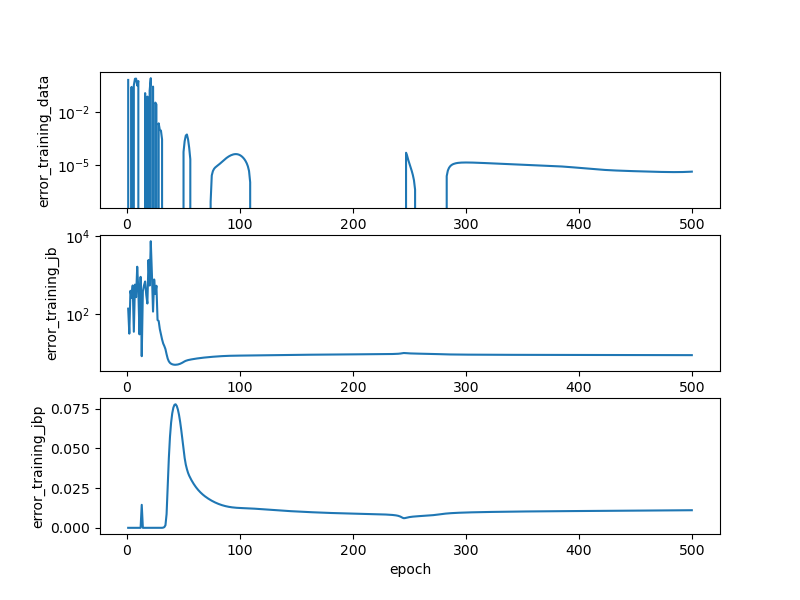

In [24]:
fig = plt.figure()
output = model.evaluate(inputs)
ax = fig.add_subplot(projection='3d')
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], output.squeeze(), s=0.1)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
model.training_log.error_training_data.mean("i").plot(ax=axs[0])
model.training_log.error_training_jb.plot(ax=axs[1])
model.training_log.error_training_jbp.plot(ax=axs[2])

axs[0].set_yscale("log")
axs[1].set_yscale("log")

### Back propagation training

In [36]:
model = FeedForwardNeuralNetwork.new(
    n_inputs=2,
    n_outputs=1,
    n_hidden=10,
    input_range=input_range
)
model

<FeedForwardNeuralNetwork
 n_inputs=2
 n_hidden=10
 n_outputs=1>

In [37]:
model.train(
    inputs,
    reference_outputs,
    epochs=10000,
    goal=1e-6,
    train_log_freq=1,
    method="trainbp",
    eta=.01,
    alpha=1.001
)

  0%|          | 0/10000 [00:00<?, ?it/s]

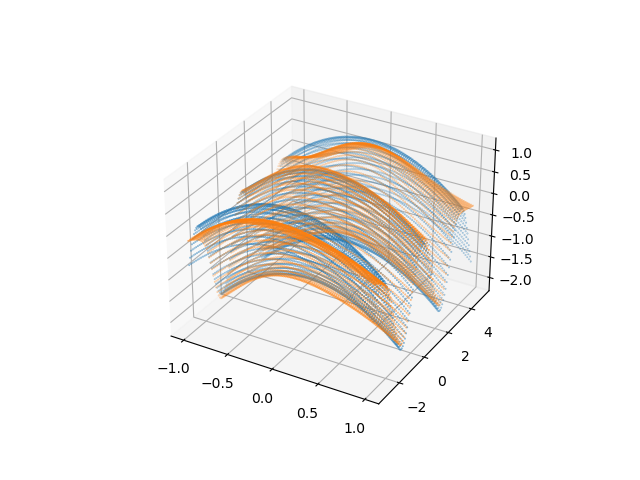

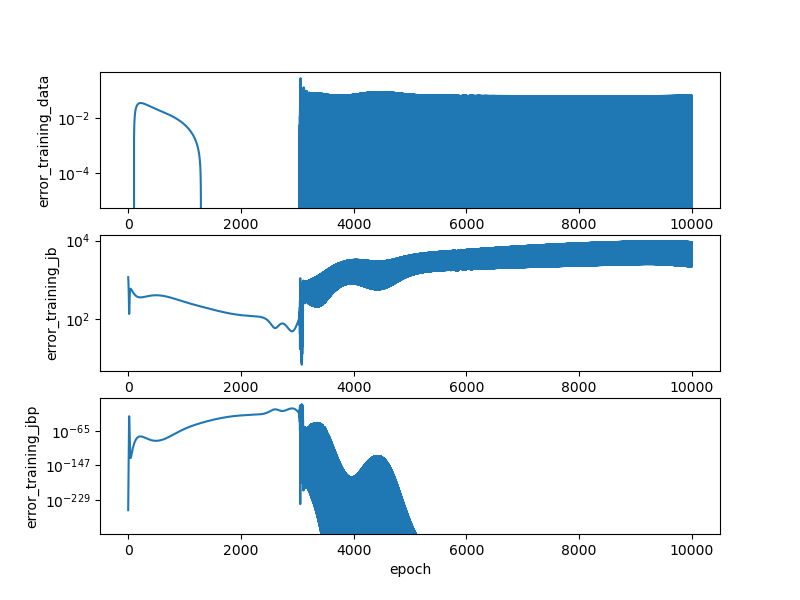

In [38]:
fig = plt.figure()
output = model.evaluate(inputs)
ax = fig.add_subplot(projection='3d')
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], output.squeeze(), s=0.1)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
model.training_log.error_training_data.mean("i").plot(ax=axs[0])
model.training_log.error_training_jb.plot(ax=axs[1])
model.training_log.error_training_jbp.plot(ax=axs[2])

axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[2].set_yscale("log")